# 시스템 손절매의 실례: 수익곡선 모멘텀 그림 2-38
- 투자 기간 :1986년 7월~2017년 6월
- 투자자산 : 코스피지수 월봉
- 투자 전략 : 12개월 평균 모멘텀 스코어 전략(연 3% 수익 가정 현금 혼합 전략) + 6개월 평균 모멘텀 스코어 시스템 손절매 전략
    - 12개월 평균 모멘텀 스코어 전략(현금 혼합)으로 전략이 마무리 되는 것이 아니라, 이 수익곡선 자체의 모멘텀 스코어를 매달 평가하여 기본 전략의 투자 비중을 매달 조절하는 전략입니다. 
    - 예를 들어 이번 달의 수익곡선 모멘텀 스코어가 0.75이었다면, 투자 비중은 평균 모멘텀 스코어 전략 75%, 현금 25%가 됩니다. 이중 75%만 전략에 투자합니다.
- 결과
    - 코스피 : 7.2%/-73.1%
    - 평균 모멘텀 스코어 현금 혼합 전략 : 6.4%/-19.1%
    - 수익곡선 모멘텀 전략 : 6.4%/-10.2%
    - 일종의 **시장 적응 전략(Market Adaptive Strategy)**

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")['Close']
kospi

Date
1981-05-01    123.600
1981-05-02    123.500
1981-05-04    120.600
1981-05-06    120.700
1981-05-07    119.300
               ...   
2022-02-08   2746.470
2022-02-09   2768.850
2022-02-10   2771.930
2022-02-11   2747.710
2022-02-14   2704.480
Name: Close, Length: 10888, dtype: float64

In [3]:
s='1985-1-30'
e='2017-6-30'
start평균모멘텀스코어='1986-1-31'
start수익곡선모멘텀='1986-7-31'

In [4]:
# kospi = fdr.DataReader("KS11")['Close']
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


# bt 적 방법으로 구현 (일일 데이타)
- 월말 리밸런싱(run_end_of_period=True) 계산은 하루전(lag=pd.DateOffset(days=1))

- 월초 리밸런싱, 전달 종가기준 계산

## 평균모멘텀스코어 class WeighAverageMomentumScore(bt.Algo):

In [5]:
class WeighAverageMomentumScore(bt.Algo):
    def __init__(self, months=12, lag=pd.DateOffset(days=0), cash='현금', cash_weigh=0.0, 현금자산제외=True):
        super(WeighAverageMomentumScore, self).__init__()
        self.lookback = months
        self.lag = lag
        self.cash = cash
        self.cash_weigh = cash_weigh
        self.현금자산제외 = 현금자산제외

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        # print("===", selected)
        if self.현금자산제외: # 현금자산빼고 모멘텀 비중나누고 나머지는 현금으로 , 아니면 현금도 하나의 자산으로
            selected.remove(self.cash)

        t0 = target.now - self.lag

        if target.universe[selected].index[0] > (t0 - pd.DateOffset(months=self.lookback)): # !!!
            return False

        momentums_score = 0
        for lookback in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=lookback)
            prc = target.universe[selected].loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        average_momentum_score = momentums_score / self.lookback
#         print(average_momentum_score)

        average_momentum_score *= (1 - self.cash_weigh)
        
        # XXX systrader79/backtesting/ebook/dynamic/10.mxied_korea_us.py 수정필요
        if self.현금자산제외: ## XXX 이 로직이 맞는지 모르겠음
            weights = average_momentum_score/len(selected) 
            weights = pd.Series(weights, index=selected)
            weights[self.cash] = 1-weights.sum()
        else:
            weights = average_momentum_score/average_momentum_score.sum()
            weights = pd.Series(weights, index=selected)


        target.temp['weights'] = weights

        return True

In [6]:
def average_momentum_score_mixed_cash(name, data, months=12, lag=pd.DateOffset(days=0), cash='현금', 현금자산제외=False):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectAll(),
            WeighAverageMomentumScore(months=months, lag=lag, cash=cash, 현금자산제외=현금자산제외),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

In [7]:
# 월말, 계산은 하루전
bt_ams_mixed_cash = average_momentum_score_mixed_cash("평균모멘텀스코어(현금혼합)", data_daily, 12, pd.DateOffset(days=1), '현금')
r_ams_mixed_cash = bt.run(bt_ams_mixed_cash)

1986-01-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-02-28 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-03-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-04-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-05-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-06-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-07-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1986-08-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-09-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.455 현금:0.545 
1986-10-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.400 현금:0.600 
1986-11-29 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1986-12-26 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-01-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-02-28 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-03-31 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.500 현금:0.500 
1987-04-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1987-05-30 00:00:00 평균모멘텀스코어(현금혼합) KOSPI:0.478 현금:0.522 
1987-06-30 00:00:00 평균모멘텀스코어(현금

In [8]:
r_ams_mixed_cash.set_date_range(start수익곡선모멘텀, e)
r_ams_mixed_cash.display()

Stat                 평균모멘텀스코어(현금혼합)
-------------------  ----------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         575.81%
Daily Sharpe         0.77
Daily Sortino        1.23
CAGR                 6.38%
Max Drawdown         -21.28%
Calmar Ratio         0.30

MTD                  1.07%
3m                   5.56%
6m                   9.43%
YTD                  9.43%
1Y                   10.80%
3Y (ann.)            3.65%
5Y (ann.)            2.81%
10Y (ann.)           3.62%
Since Incep. (ann.)  6.38%

Daily Sharpe         0.77
Daily Sortino        1.23
Daily Mean (ann.)    6.19%
Daily Vol (ann.)     8.08%
Daily Skew           -0.10
Daily Kurt           6.92
Best Day             3.82%
Worst Day            -4.07%

Monthly Sharpe       0.73
Monthly Sortino      1.60
Monthly Mean (ann.)  6.59%
Monthly Vol (ann.)   8.98%
Monthly Skew         0.93
Monthly Kurt         2.60
Best Month           10.91%
Worst Month 

In [9]:
bt_kospi1 = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
bt_현금1 = long_only_ew(data_daily, ['현금'], '현금')

In [10]:
r_kospi1 = bt.run(bt_kospi1)
r_현금1 = bt.run(bt_현금1)

1985-01-30 00:00:00
1985-01-30 00:00:00


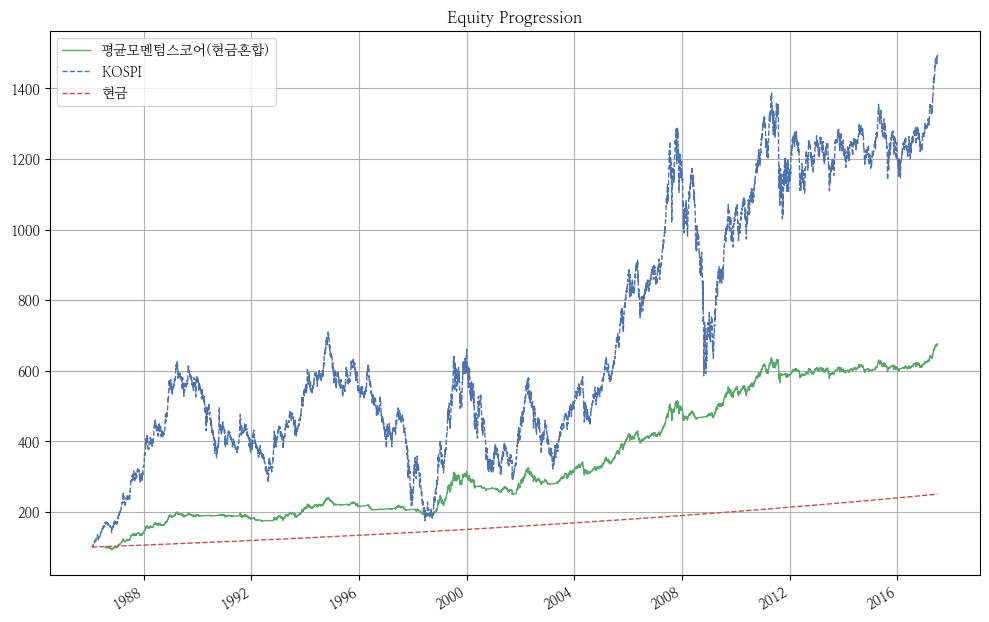

In [11]:
r_kospi1.set_date_range(start평균모멘텀스코어, e)
r_현금1.set_date_range(start평균모멘텀스코어, e)

# %%
ax1 = r_ams_mixed_cash.plot(color='g', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금1.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));

## 수익곡선모멘텀

In [12]:
r_ams_mixed_cash.set_date_range(start평균모멘텀스코어)
r_ams_mixed_cash.prices

,평균모멘텀스코어(현금혼합)
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,892.959
2017-06-27,893.614
2017-06-28,891.881
2017-06-29,894.383


## 데이타 생성

In [13]:
data_daily2 = pd.DataFrame()
data_daily2['수익곡선모멘텀6'] = r_ams_mixed_cash.prices
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(start평균모멘텀스코어, e, freq='D')
denominator = len(pd.date_range(start평균모멘텀스코어, e, freq='D'))/len(pd.date_range(start평균모멘텀스코어, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily2 = pd.merge(data_daily2, dd, left_index=True, right_index=True, how='left')

In [14]:
data_daily2

,수익곡선모멘텀6,현금
1986-01-31,100.000,1.000
1986-02-01,100.609,1.000
1986-02-03,100.910,1.000
1986-02-04,100.723,1.000
1986-02-05,100.411,1.000
...,...,...
2017-06-26,892.959,2.499
2017-06-27,893.614,2.499
2017-06-28,891.881,2.499
2017-06-29,894.383,2.500


In [15]:
bt_returns_curve_mom = average_momentum_score_mixed_cash(
                       "평균모멘텀스코어(현금혼합)+수익곡선모멘텀", 
                       data_daily2, 
                       6, 
                       pd.DateOffset(days=1), 
                       '현금', 
                       현금자산제외=True)
r_returns_curve_mom = bt.run(bt_returns_curve_mom)

1986-07-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-08-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-09-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.667 현금:0.333 
1986-10-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.500 현금:0.500 
1986-11-29 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1986-12-26 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-01-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-02-28 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-03-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-04-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-05-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-06-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-07-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:1.000 현금:0.000 
1987-08-31 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모멘텀6:0.833 현금:0.167 
1987-09-30 00:00:00 평균모멘텀스코어(현금혼합)+수익곡선모멘텀 수익곡선모

In [16]:
r_returns_curve_mom.set_date_range(start수익곡선모멘텀,e)
r_returns_curve_mom.display()

Stat                 평균모멘텀스코어(현금혼합)+수익곡선모멘텀
-------------------  -------------------------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         560.43%
Daily Sharpe         0.88
Daily Sortino        1.40
CAGR                 6.30%
Max Drawdown         -12.88%
Calmar Ratio         0.49

MTD                  1.07%
3m                   5.56%
6m                   9.28%
YTD                  9.28%
1Y                   10.30%
3Y (ann.)            4.23%
5Y (ann.)            2.86%
10Y (ann.)           3.28%
Since Incep. (ann.)  6.30%

Daily Sharpe         0.88
Daily Sortino        1.40
Daily Mean (ann.)    6.03%
Daily Vol (ann.)     6.81%
Daily Skew           0.03
Daily Kurt           10.59
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.85
Monthly Sortino      1.99
Monthly Mean (ann.)  6.40%
Monthly Vol (ann.)   7.53%
Monthly Skew         1.41
Monthly Kurt         4.96
Best Month       

In [17]:
r_returns_curve_mom.prices.resample('M').last().to_drawdown_series().describe()

,평균모멘텀스코어(현금혼합)+수익곡선모멘텀
count,372.000
mean,-0.034
std,0.026
min,-0.100
25%,-0.052
50%,-0.032
75%,-0.009
max,0.000


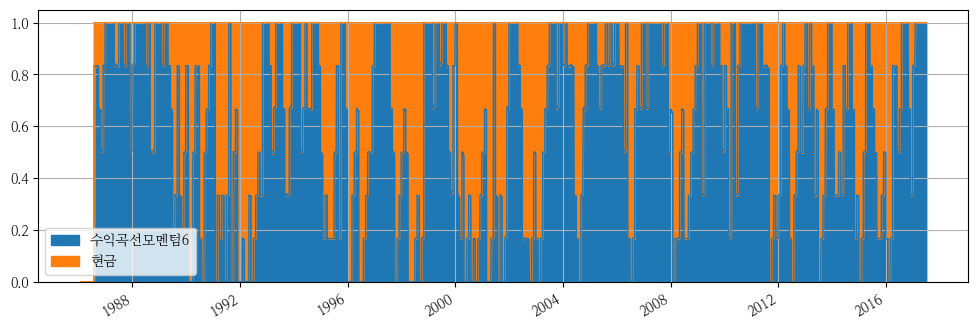

In [18]:
r_returns_curve_mom.get_security_weights().plot.area(figsize=(12,4));

In [19]:
r_returns_curve_mom.prices

,평균모멘텀스코어(현금혼합)+수익곡선모멘텀
1986-07-31,100.000
1986-08-01,99.063
1986-08-02,99.644
1986-08-04,99.583
1986-08-05,99.209
...,...
2017-06-26,659.886
2017-06-27,660.370
2017-06-28,659.089
2017-06-29,660.939


                        CAGR
평균모멘텀스코어(현금혼합)+수익곡선모멘텀 6.296
                           MDD
평균모멘텀스코어(현금혼합)+수익곡선모멘텀 -12.881


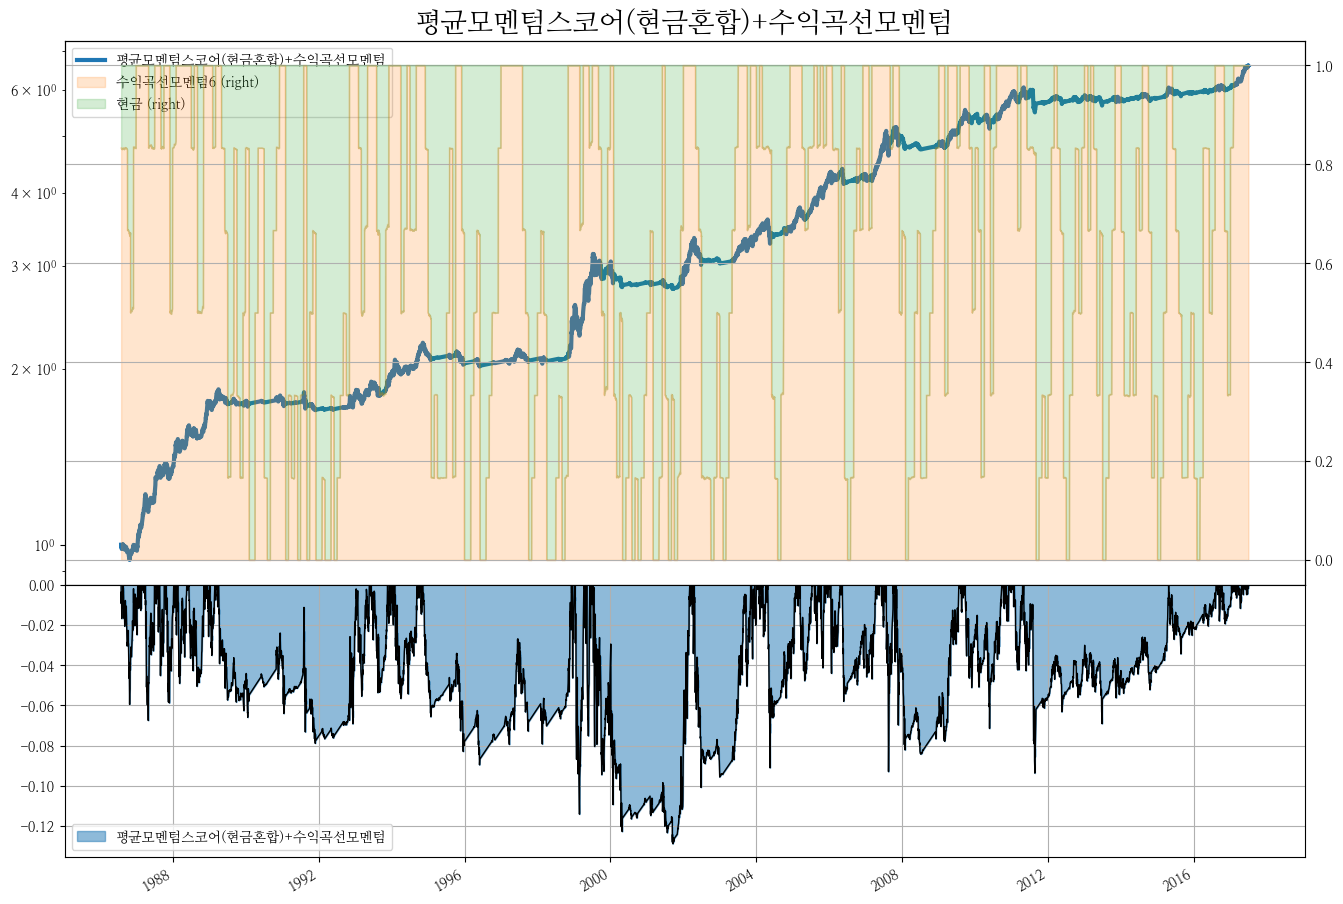

In [20]:
plot_assets(r_returns_curve_mom, start수익곡선모멘텀, e, "평균모멘텀스코어(현금혼합)+수익곡선모멘텀")

## 그림 2.38 (일간, bt적 알고)

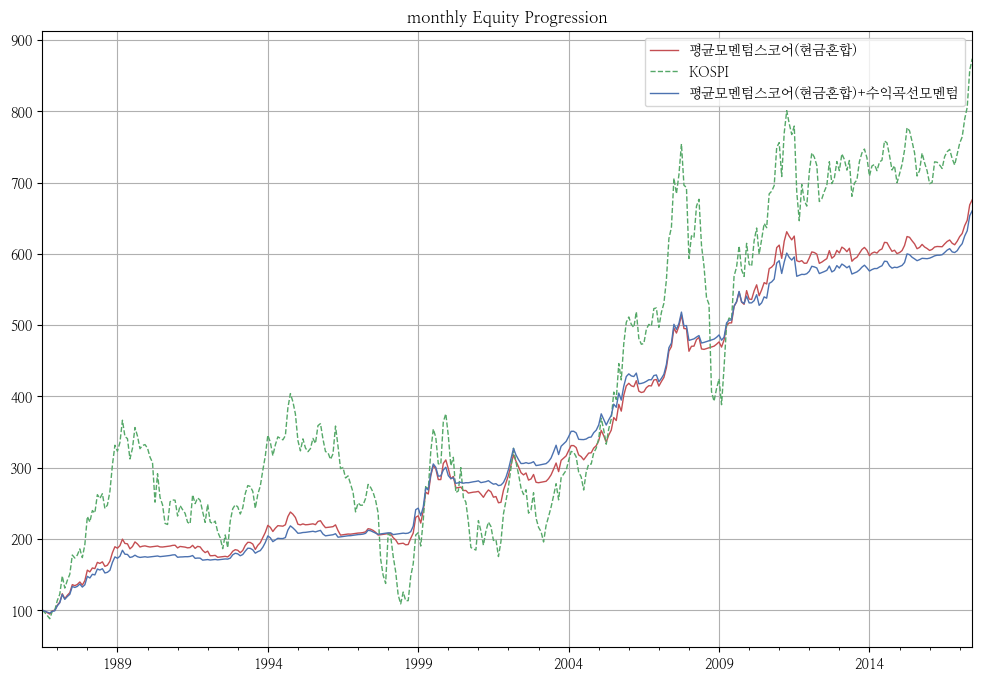

In [21]:
r_ams_mixed_cash.set_date_range(start수익곡선모멘텀)
r_kospi1.set_date_range(start수익곡선모멘텀)
r_returns_curve_mom.set_date_range(start수익곡선모멘텀)

ax1 = r_ams_mixed_cash.plot(color='r', freq='M', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='g', freq='M', figsize=(12, 8));
r_returns_curve_mom.plot(ax=ax1, ls='-', color='b', freq='M', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

## 비교
- 월별 비중 데이터프레임
  - CAGR                 6.43%/Max Drawdown         -19.12%
  - CAGR                 6.44%/Max Drawdown         -10.19% (수익곡선모멘텀6)
  
- 일일데이터 비중 클래스
  - CAGR                 6.41%/Max Drawdown         -21.13%
  - CAGR                 6.39%/ Max Drawdown         -13.74% (수익곡선모멘텀6)

- bt적 방법 (월말 리밸런싱, 1일전기준 계산)
  - CAGR                 6.38%/Max Drawdown         -21.28%
  - CAGR                 6.30%/Max Drawdown         -12.88% (수익곡선모멘텀6)